# Simulation with Pure NumPy

@[Chaoming Wang](https://github.com/chaoming0625)

Most of computations in BrainPy relies on [JAX](https://github.com/google/jax). However, numba is another excellent JIT compiler in Python scientific computing ecosystem. Moreover, it enables more flexible model definition with pure Python syntax. BrainPy supports model simualtion with pure NumPy backend, and model acceleration with JIT compilation of [Numba](https://numba.pydata.org/). 

[Numba](https://github.com/numba/numba) is specialized to optimize your native NumPy codes, including NumPy arrays, loops and condition controls, etc. It is a cross-platform library which can run on Windows, Linux, macOS, etc. The most wonderful thing is that numba can just-in-time compile your native Python loops (``for`` or ``while`` syntaxs) and condition controls (``if ... else ...``). This means that it supports your intutive Python programming. 

However, Numba is a lightweight JIT compiler, and is just suitable for small network models. For large networks, the parallel performance is poor. Futhermore, numba doesn't support `one code runs on multiple devices`. Same code cannot run on GPU targets.

In this tutorial, we are going to talk about how to simulate models with pure NumPy syntax and accelerate models with Numba JIT. 

In [1]:
import numpy as np

import brainpy as bp
from brainpy.math.numpy import Variable, jit

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

Our tutorial is based on the E/I balance network COBA which is adopted from (Vogels & Abbott, 2005) [1].

In [3]:
# Parameters for network structure
num = 4000
num_exc = int(num * 0.75)
num_inh = int(num * 0.25)

**Neuron Model**

In COBA network, each integrate-and-fire neuron is characterized by a time constant, $\tau$ = 20 ms, and a resting membrane potential, $V_{rest}$ = -60 mV. Whenever the membrane potential crosses a spiking threshold of -50 mV, an action potential is generated and the membrane potential is reset to the resting potential, where it remains clamped for a 5 ms refractory period. The membrane voltages are calculated as follows:

$$
\tau {dV \over dt} = (V_{rest} - V) + g_{exc}(E_{exc} - V) + g_{inh}(E_{inh} - V)
$$

where reversal potentials are $E_{exc} = 0$ mV and $E_{inh} = -80$ mV. 

In [4]:
# Parameters for the neuron
tau = 20  # ms
Vt = -50  # mV
Vr = -60  # mV
El = -60  # mV
ref_time = 5.0  # refractory time, ms
I = 20.

In [5]:
class LIF(bp.NeuGroup):
  def __init__(self, size, **kwargs):
    super(LIF, self).__init__(size=size, **kwargs)

    # variables
    self.V = Variable(np.random.randn(size) * 2. + Vr)
    self.input = Variable(np.zeros(size))
    self.spike = Variable(np.zeros(size, dtype=bool))
    self.t_last_spike = Variable(np.ones(size) * -1e7)

    # function
    self.integral = bp.odeint(self.derivative)

  def derivative(self, V, t, Iexc):
    dV = (Iexc + El - V) / tau
    return dV

  def update(self, _t, _dt):
    for i in range(self.num):
      self.spike[i] = 0.
      if (_t - self.t_last_spike[i]) > ref_time:
        V = self.integral(self.V[i], _t, self.input[i])
        if V >= Vt:
          self.V[i] = Vr
          self.spike[i] = 1.
          self.t_last_spike[i] = _t
        else:
          self.V[i] = V
      self.input[i] = I

**Synapse Model**

In COBA network, when a neuron fires, the appropriate synaptic variable of its postsynaptic targets are increased, $g_{exc} \gets g_{exc} + \Delta g_{exc}$ for an excitatory presynaptic neuron and $g_{inh} \gets g_{inh} + \Delta g_{inh}$ for an inhibitory presynaptic neuron. Otherwise, these parameters obey the following equations:

$$
\tau_{exc} {dg_{exc} \over dt} = -g_{exc} \quad \quad (1) \\
\tau_{inh} {dg_{inh} \over dt} = -g_{inh} \quad \quad (2)
$$

with synaptic time constants $\tau_{exc} = 5$ ms, $\tau_{inh} = 10$ ms, $\Delta g_{exc} = 0.6$ and $\Delta g_{inh} = 6.7$. 

In [6]:
# Parameters for the synapse
tau_exc = 5  # ms
tau_inh = 10  # ms
E_exc = 0.  # mV
E_inh = -80.  # mV
delta_exc = 0.6  # excitatory synaptic weight
delta_inh = 6.7  # inhibitory synaptic weight

In [7]:
class EINet(bp.Network):
  def __init__(self, neu_model, syn_model):
    E = neu_model(num_exc)
    I = neu_model(num_inh)
    E2E = syn_model(E, E, bp.conn.FixedProb(0.02), tau=tau_exc, weight=delta_exc, E=E_exc)
    E2I = syn_model(E, I, bp.conn.FixedProb(0.02), tau=tau_exc, weight=delta_exc, E=E_exc)
    I2E = syn_model(I, E, bp.conn.FixedProb(0.02), tau=tau_inh, weight=delta_inh, E=E_inh)
    I2I = syn_model(I, I, bp.conn.FixedProb(0.02), tau=tau_inh, weight=delta_inh, E=E_inh)
    super(EINet, self).__init__(E2E, E2I, I2E, I2I, E=E, I=I)

    self.all_steps = [node.update for node in self.child_ds().values()]

  def update(self, _t, _dt):
    for step in self.all_steps:
      step(_t, _dt)

In [8]:
def run_net(neu_model, syn_model):
  net = jit(EINet(neu_model, syn_model))
  runner = bp.NumpyRunner(net, report=0.1, monitors=['E.spike', 'I.spike'])
  t = runner.run(100.)

  fig, gs = bp.visualize.get_figure(row_num=5, col_num=1, row_len=1, col_len=10)
  fig.add_subplot(gs[:4, 0])
  bp.visualize.raster_plot(runner.mon.ts, runner.mon['E.spike'], xlim=(0, 100.), ylabel='E Group', xlabel='')
  fig.add_subplot(gs[4, 0])
  bp.visualize.raster_plot(runner.mon.ts, runner.mon['I.spike'], xlim=(0, 100.), ylabel='I Group', show=True)

  return t

## Matrix-based connection

The matrix-based synaptic connection is one of the most intuitive way to build synaptic computations. The connection matrix between two neuron groups can be easily obtained through the function of `connector.requires('conn_mat')` (details please see [Synaptic Connectivity](./tutorial_building/synaptic_connectivity.ipynb)). Each connection matrix is an array with the shape of `(num_pre, num_post)`, like 

<img src="../_static/syn-example-conn_mat.png" width="400 px">

Based on `conn_mat`, the updating logic of the above synapses can be coded as:

In [9]:
class SynMat1(bp.TwoEndConn):
  def __init__(self, pre, post, conn, tau, weight, E, **kwargs):
    super(SynMat1, self).__init__(pre=pre, post=post, conn=conn, **kwargs)

    # parameters
    self.tau = tau
    self.weight = weight
    self.E = E

    # p1: connections
    self.conn_mat = np.asarray(self.conn.requires('conn_mat'))

    # variables
    self.g = Variable(np.zeros(self.conn_mat.shape))
    
    # function
    self.integral = bp.odeint(self.derivative)
  
  def derivative(self, g, t):
    dg = - g / self.tau
    return dg

  def update(self, _t, _dt):
    self.g[:] = self.integral(self.g, _t)
    spike_on_syn = np.expand_dims(self.pre.spike, 1) * self.conn_mat  # p2
    self.g[:] += spike_on_syn * self.weight  # p3
    self.post.input[:] += np.sum(self.g, axis=0) * (self.E - self.post.V)  # p4

In the above defined `SynMat1` class, at "p1" line we requires a "conn_mat" structure for the later synaptic computation; at "p2" we get spikes for each synaptic connections according to "conn_mat" and "presynaptic spikes"; then at "p3", the spike-triggered synaptic variables are added onto its postsynaptic targets; at final "p4" code line, all connected synaptic values are summed to get the current effective conductance by *np.sum(self.g, axis=0)*. 

Now, let's inspect the performance of this matrix-based synapse. 

Compilation used 13.2136 s.
Start running ...
Run 10.0% used 20.290 s.
Run 20.0% used 40.049 s.
Run 30.0% used 59.751 s.
Run 40.0% used 79.500 s.
Run 50.0% used 99.244 s.
Run 60.0% used 118.977 s.
Run 70.0% used 138.652 s.
Run 80.0% used 158.449 s.
Run 90.0% used 178.375 s.
Run 100.0% used 198.661 s.
Simulation is done in 198.661 s.



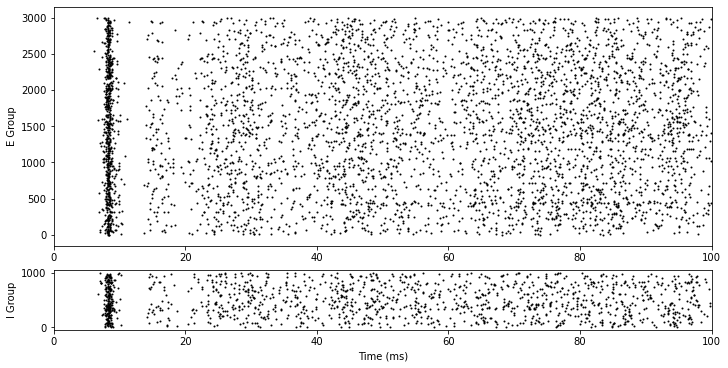

In [10]:
t_syn_mat1 = run_net(neu_model=LIF, syn_model=SynMat1)

This matrix-based synapse structure is very inefficient, because 99.9% time were wasted on the synaptic computation. We can inspect this by only running the neuron group models. 

In [11]:
group = jit(LIF(num))
runner = bp.NumpyRunner(group, inputs=('input', 5.), monitors=['spike'])
runner.run(100.)

Compilation used 0.2510 s.
Start running ...
Run 10.0% used 0.002 s.
Run 20.0% used 0.004 s.
Run 30.0% used 0.007 s.
Run 40.0% used 0.011 s.
Run 50.0% used 0.014 s.
Run 60.0% used 0.017 s.
Run 70.0% used 0.019 s.
Run 80.0% used 0.022 s.
Run 90.0% used 0.028 s.
Run 100.0% used 0.038 s.
Simulation is done in 0.038 s.



0.037975311279296875

As you can see, the neuron group only spends 0.026 s to run. After normalized by the total running time 120+ s, the neuron group running only accounts for about 0.02 %. 

## Event-based updating

The inefficiency in the above matrix-based computation comes from the horrendous waste of time on synaptic computation. First, it is uncommon for a neuron to generate a spike; Second, in a group of neuron, the generated spikes (`self.pre.spike`) are usually sparse. Therefore, at many time points, there are many zeros in `self.pre.spike`, which results `self.g` add many unnecessary zeros (`self.g += spike_on_syn * self.weight`). 

Alternatively, we can update `self.g` only when the pre-synaptic neuron produces a spike event (this is called as the **event-based updating** method):

In [12]:
class SynMat2(bp.TwoEndConn):
  def __init__(self, pre, post, conn, tau, weight, E, **kwargs):
    super(SynMat2, self).__init__(pre=pre, post=post, conn=conn, **kwargs)

    # parameters
    self.tau = tau
    self.weight = weight
    self.E = E

    # connections
    self.conn_mat = np.asarray(self.conn.requires('conn_mat'))

    # variables
    self.g = Variable(np.zeros(self.conn_mat.shape))

    # function
    self.integral = bp.odeint(self.derivative)

  def derivative(self, g, t):
    dg = - g / self.tau
    return dg

  def update(self, _t, _dt):
    self.g[:] = self.integral(self.g, _t)
    # p1
    for pre_i, spike in enumerate(self.pre.spike):
      if spike:
        self.g[pre_i] += self.conn_mat[pre_i] * self.weight
    self.post.input[:] += np.sum(self.g, axis=0) * (self.E - self.post.V)

Compared to `SynMat1`, we replace "p2" and "p3" in `SynMat1` with "p1" in `SynMat2`. Now, the updating logic is only when the pre-synaptic neuron emits a spike (`if spike`), the connected post-synaptic state `g` will be updated (`self.g[pre_i] += self.conn_mat[pre_i] * self.weight`).

Compilation used 11.5781 s.
Start running ...
Run 10.0% used 9.614 s.
Run 20.0% used 19.398 s.
Run 30.0% used 29.312 s.
Run 40.0% used 39.179 s.
Run 50.0% used 48.968 s.
Run 60.0% used 58.802 s.
Run 70.0% used 68.529 s.
Run 80.0% used 78.316 s.
Run 90.0% used 88.162 s.
Run 100.0% used 97.950 s.
Simulation is done in 97.950 s.



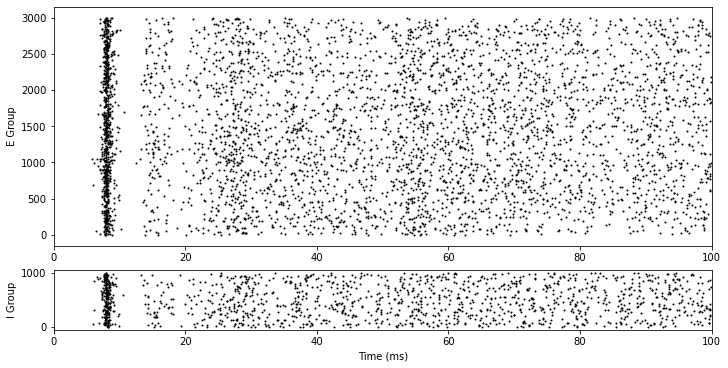

In [13]:
t_syn_mat2 = run_net(neu_model=LIF, syn_model=SynMat2)

Such event-based matrix connection boosts the running speed nearly 2 times, but it's not good enough.

## Vector-based connection

Matrix-based synaptic computation may be straightforward, but can cause severe wasted RAM memory and inefficient computation. Imaging you want to connect 10,000 pre-synaptic neurons to 10,000 post-synaptic neurons with a 10% random connection probability. Using *matrix*, you need $10^8$ floats to save the synaptic state, and at each update step, you need do computation on $10^8$ floats. Actually, the number of values you really needed is only $10^7$. See, there is a huge memory waste and computing resource inefficiency. 

## `pre_ids` and `post_ids`

An effective method to solve this problem is to use *vector* to store the connectivity between neuron groups and the corresponding synaptic states. For the above defined connectivity `conn_mat`, we can align the connected pre-synaptic neurons and the post-synaptic neurons by two one-dimensional arrays: *pre_ids* and *post_ids*,

<img src="../_static/syn-example-pre_ids-post_ids.png" width="700 px">

In such a way, we only need two vectors (`pre_ids` and `post_ids`, each has $10^7$ floats) to store the synaptic connectivity. And, at each time step, we just need update a synaptic state vector with $10^7$ floats. 

In [14]:
class SynVec1(bp.TwoEndConn):
  def __init__(self, pre, post, conn, tau, weight, E, **kwargs):
    super(SynVec1, self).__init__(pre=pre, post=post, conn=conn, **kwargs)

    # parameters
    self.tau = tau
    self.weight = weight
    self.E = E

    # connections
    pre_ids, post_ids = self.conn.requires('pre_ids', 'post_ids')
    self.pre_ids = np.asarray(pre_ids)
    self.post_ids = np.asarray(post_ids)
    self.num = len(self.pre_ids)

    # variables
    self.g = Variable(np.zeros(self.num))
    
    # function
    self.integral = bp.odeint(self.derivative)

  def derivative(self, g, t):
    dg = - g / self.tau
    return dg

  def update(self, _t, _dt):
    self.g[:] = self.integral(self.g, _t)
    for syn_i in range(self.num):
      # p1: update
      pre_i = self.pre_ids[syn_i]
      if self.pre.spike[pre_i]:
        self.g[syn_i] += self.weight
      # p2: output
      post_i = self.post_ids[syn_i]
      self.post.input[post_i] += self.g[syn_i] * (self.E - self.post.V[post_i])

In `SynVec1` class, we first update the synaptic state with "p1" code block, in which the synaptic state `self.g[syn_i]` is updated when the pre-synaptic neuron generates a spike (`if self.pre.spike[pre_i]`); then, at "p2" code block, we output the synaptic states onto the post-synaptic neurons. 

Compilation used 4.2681 s.
Start running ...
Run 10.0% used 0.146 s.
Run 20.0% used 0.295 s.
Run 30.0% used 0.445 s.
Run 40.0% used 0.593 s.
Run 50.0% used 0.742 s.
Run 60.0% used 0.890 s.
Run 70.0% used 1.080 s.
Run 80.0% used 1.228 s.
Run 90.0% used 1.378 s.
Run 100.0% used 1.526 s.
Simulation is done in 1.526 s.



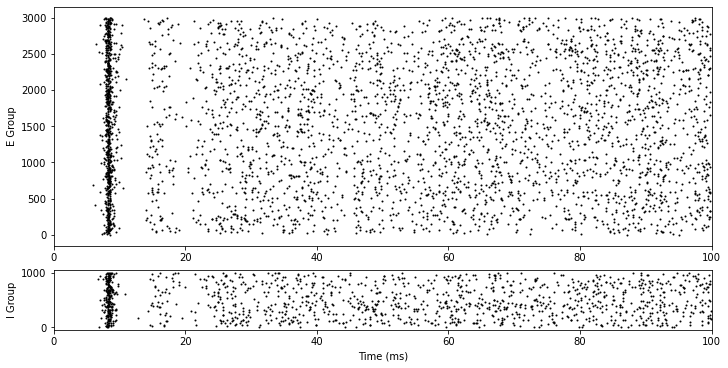

In [15]:
t_syn_vec1 = run_net(neu_model=LIF, syn_model=SynVec1)

Great! Transform the matrix-based connection into the vector-based connection makes us get a huge speed boost. However, there also exists redundant part in `SynVec1` class. This is because a pre-synaptic neuron may connect to many post-synaptic neurons and thus at each step updating we will judge a pre-synaptic neuron whether generates a spike many times (`self.pre.spike[pre_i]`).

## `pre2post`

Notice that for this kind of synapse model, the synaptic states $g$ onto a post-synaptic neuron can be modeled together. This is because the synaptic state evolution according to the differential equation (1) and (2) after the pre-synaptic spikes can be superposed. This means that we can declare a synaptic state `self.g` with the shape of `post.num`, not the shape of the synapse number.

In order to achieve this goal, we create another synaptic structure (`pre2post`) which establish the direct mapping between the pre-synaptic neurons and the post-synaptic neurons. More deatils please see [Synaptic Connectivity](./tutorial_building/synaptic_connectivity.ipynb). 

In [16]:
class SynVec5(bp.TwoEndConn):
  def __init__(self, pre, post, conn, tau, weight, E, **kwargs):
    super(SynVec5, self).__init__(pre=pre, post=post, conn=conn, **kwargs)

    # parameters
    self.tau = tau
    self.weight = weight
    self.E = E

    # connections
    pre2post = self.conn.requires('pre2post')
    self.post_ids = np.asarray(pre2post[0])
    self.idnptr = np.asarray(pre2post[1])

    # variables
    self.g = Variable(np.zeros(post.num))

    # function
    self.integral = bp.odeint(self.derivative)

  def derivative(self, g, t):
    dg = - g / self.tau
    return dg

  def update(self, _t, _dt):
    self.g[:] = self.integral(self.g, _t)
    # p1: update
    for pre_i in range(self.pre.num):
      if self.pre.spike[pre_i]:
        start = self.idnptr[pre_i]
        end = self.idnptr[pre_i + 1]
        for post_i in self.post_ids[start: end]:
          self.g[post_i] += self.weight
    # p2: output
    self.post.input[:] += self.g * (self.E - self.post.V)

Compilation used 5.7620 s.
Start running ...
Run 10.0% used 0.005 s.
Run 20.0% used 0.010 s.
Run 30.0% used 0.015 s.
Run 40.0% used 0.020 s.
Run 50.0% used 0.026 s.
Run 60.0% used 0.031 s.
Run 70.0% used 0.036 s.
Run 80.0% used 0.041 s.
Run 90.0% used 0.047 s.
Run 100.0% used 0.053 s.
Simulation is done in 0.053 s.



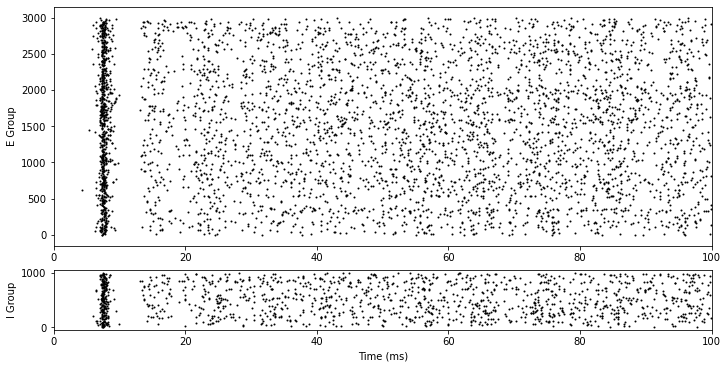

In [17]:
t_syn_vec2 = run_net(neu_model=LIF, syn_model=SynVec5)

## Speed comparison

We illustrate their efficiency by a spare randomly connected E/I balance network COBA [1]. We summarize their speed in the following comparison figure:

In [18]:
names = ['mat', 'event mat', 'pre_ids/post_ids', 'pre2post']
times = [t_syn_mat1, t_syn_mat2, t_syn_vec1, t_syn_vec2]
xs = list(range(len(times)))

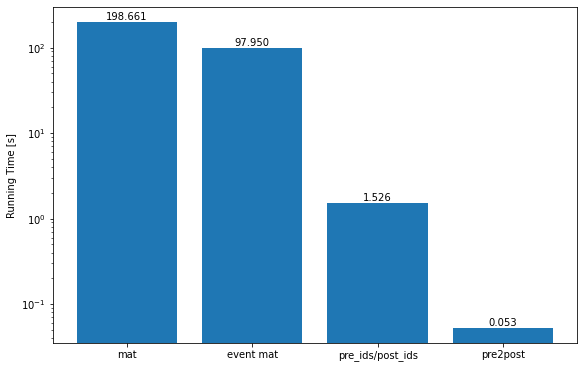

In [19]:
def autolabel(rects):
  """Attach a text label above each bar in *rects*, displaying its height."""
  for rect in rects:
    height = rect.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 0.5),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')


fig, gs = bp.visualize.get_figure(1, 1, 5, 8)

ax = fig.add_subplot(gs[0, 0])
rects = ax.bar(xs, times)
ax.set_xticks(xs)
ax.set_xticklabels(names)
ax.set_yscale('log')
plt.ylabel('Running Time [s]')
autolabel(rects)

However, the speed comparison presented here does not mean that the vector-based connection is always better than the matrix-based connection. Vector-based synaptic model is well suitable to simulate spare connections. Whereas the matrix-based synaptic model is best to solve problems for dense connections, such like all-to-all connection.

More synapse models please see [BrainModels](https://brainmodels.readthedocs.io/en/latest/apis/synapses.html).

---

**References**:

[1] Vogels, T. P. and Abbott, L. F. (2005), Signal propagation and logic gating in networks of integrate-and-fire neurons., J. Neurosci., 25, 46, 10786–95
